# Running global evolution

The aim of this tutorial is to show how `21cmFAST` can be used to compute gloabl quantities in seconds, and clarify what assumptions are taken in that calculation, compared to a standard lightcone run.

In [1]:
import matplotlib.pyplot as plt
from tempfile import mkdtemp
import py21cmfast as p21c

In [2]:
print(f' Using 21cmFAST version {p21c.__version__}')

 Using 21cmFAST version 4.0.0b1.dev578+g43e19f1a3.d20260129


## Run a simulation using `run_lightcone`

Suppose we want to compute the global signal, before running a full detailed simulation. In older versions of `21cmFAST` this would require us to call `run_lightcone`.

Specifying input parameters is a topic covered in a [different tutorial](defining_input_params.html).
Here, we want something small and fast, so we use the `"tiny"` configuration, together with the `"fixed-halos"` template, since we also want to explore the evolution of the star formation rate density (SFRD) in the simulation. We also adjust the `zmax` and `zstep_factor` arguments in order to have a smoother evolution (more redshift snapshots).

In [3]:
inputs = p21c.InputParameters.from_template(
    ["fixed-halos", "tiny"], random_seed=1234
).with_logspaced_redshifts(
    zmax = 35., 
    zstep_factor = 1.02,
)

/Users/jordanflitter/miniconda3/envs/V4_ENV/lib/python3.12/site-packages/attr/_make.py:3279: UserWarning: You are setting R_BUBBLE_MAX != 50 when INHOMO_RECO=True. This is non-standard (but allowed), and usually occurs upon manual update of INHOMO_RECO
  v(inst, attr, value)
/Users/jordanflitter/miniconda3/envs/V4_ENV/lib/python3.12/site-packages/py21cmfast/wrapper/inputs.py:1939: UserWarning: The maximum halo mass 1.33e+11 solMass is below the integral mass 1.00e+16 solMass. Halos above 1.33e+11 solMass will not be accounted for in the simulation.
  check_halomass_range(self)


We configure the cache and lightconer below.

In [4]:
cache = p21c.OutputCache(mkdtemp())
cacheconfig = p21c.CacheConfig.last_step_only()

In [5]:
lightconer = p21c.RectilinearLightconer.between_redshifts(
    min_redshift=inputs.node_redshifts[-1]+0.5,
    max_redshift=inputs.node_redshifts[0]-0.5,
    resolution=inputs.simulation_options.cell_size,
    cosmo=inputs.cosmo_params.cosmo,
)

And now we run the lightcone simulation!

In [6]:
lightcone = p21c.run_lightcone(
    lightconer=lightconer,
    inputs=inputs,
    cache=cache,
    write=cacheconfig,
    progressbar=True
)

Output()

Output()

## Run a simulation using `run_global_evolution`

When `21cmFAST` computes the global quantities from a `run_lightcone` simulation, it does the following at each redshift snapshot (i.e. at each entry of `node_redshifts`); first it evaluates a coeval box that contains all the fields in the simulation, then, for each field in the coeval box, it computes the mean value.

The abve procedure may seem computationally expensive for just getting the mean value of the fields. If we are only interested in plotting the global quantities, without caring about the spatial fluctuations, do we really have to run a full lightcone simulation? Can't we run a single cell simulation with zero overdensity ($\delta=0$), just to get the global evolution of the fields? In other words, how valid is the approximation $\langle f(\delta)\rangle\approx f(\langle \delta\rangle=0)$? This is known as the "single zone approximation", since we treat the Universe as a giant homogeneous single zone in order to evaluate mean background evolution of the fields.

Of course, if the field $f$ is given by a linear expression of $\delta$, then by definition $\langle f(\delta)\rangle=f(\langle \delta\rangle)$. This relation however is no longer guaranteed when $f$ is not a linear function of $\delta$.

For speeding up the calculation of the global signal, `21cmFAST` also has the option to compute the global evolution of all the fields in the simulation by applying the single zone approximation. This is done by running a giant single cell simulation, but without performing 2LPT (as there is no point in moving masses when there is just one cell), and without performing the excursion set algorithm to find ionized bubbles (since there are no bubbles in a box made of a single cell!).

In order to compute the global evolution of all the fields in the simulation with the single zone approximation, we call `run_global_evolution`. Note that `inputs` can contain a `SOURCE_MODEL` with discrete halos, but then the `source_model` argument must be specified, and it must not contain halos! (since we cannot define halos when we only have one cell)

Also note that unlike `run_lightcone`, `run_global_evolution` doesn't require providing a cache and lightconer settings.

In [7]:
global_evolution = p21c.run_global_evolution(
    inputs = inputs,
    source_model = "L-INTEGRAL", # can choose between "CONST-ION-EFF", "E-INTEGRAL", "L-INTEGRAL"
    progressbar = True
)

Output()

Output()

This took a lot faster than `run_lightcone`!

Note that unlike `run_lightcone`, the actual `InputParameters` instance that is used in `run_global_evolution` is not the same as `inputs`! For example, a detailed inspection will reveal that we have used a single cell and we also perturbed (the mean) density field linearly.

In [8]:
print(inputs == lightcone.inputs)
print(inputs == global_evolution.inputs)

True
False


In [9]:
print(f"HII_DIM that was used in run_lightcone: {lightcone.simulation_options.HII_DIM}.")
print(f"HII_DIM that was used in run_global_evolution: {global_evolution.simulation_options.HII_DIM}.")
print(f"Perturbation algorithm that was used in run_lightcone: {lightcone.matter_options.PERTURB_ALGORITHM}.")
print(f"Perturbation algorithm that was used in run_global_evolution: {global_evolution.matter_options.PERTURB_ALGORITHM}.")

HII_DIM that was used in run_lightcone: 32.
HII_DIM that was used in run_global_evolution: 1.
Perturbation algorithm that was used in run_lightcone: 2LPT.
Perturbation algorithm that was used in run_global_evolution: LINEAR.


## Comparison of the global evolution in both methods

Now that we have the global evolution of the fields in both methods, it is time to compare them! We compare below the SFRD (`halo_sfr`), the gas kinetic temperature, the spin temperature, the neutral fraction, the 21-cm optical depth, and the 21-cm signal (`brightness_temp`).

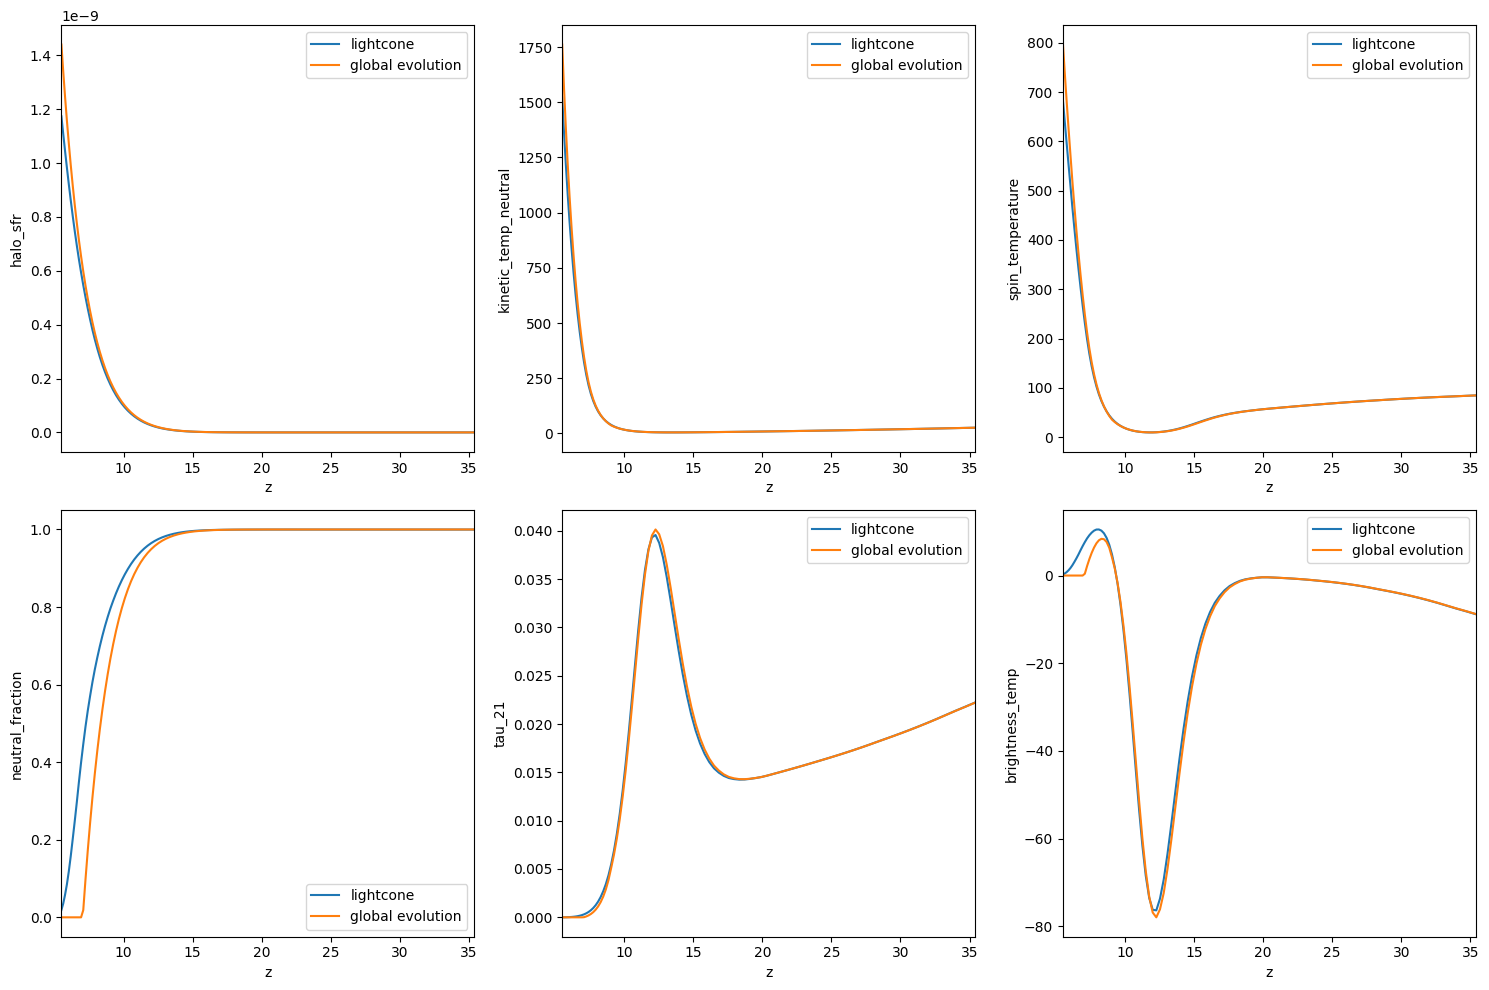

In [10]:
fields = [
    "halo_sfr",
    "kinetic_temp_neutral",
    "spin_temperature",
    "neutral_fraction",
    "tau_21",
    "brightness_temp"
]

fig, axes = plt.subplots(2, 3, figsize=(15,10))
z_array = global_evolution.node_redshifts
for ax, field in zip(axes.flatten(),fields):
    ax.plot(z_array,lightcone.global_quantities[field],label="lightcone")
    ax.plot(z_array,global_evolution.quantities[field],label="global evolution")
    ax.set_xlim([min(z_array),max(z_array)])
    ax.set_xlabel('z')
    ax.set_ylabel(field)
    ax.legend()
plt.tight_layout()

Focusing first on the top row, we see that there is an good match between the two methods. The two methods agree particularly well at high redshifts, while small differences can be seen at lower redshifts. This makes sense since at higher redshifts the fluctuations in the density field are still in the linear regime ($|\delta|\ll 1$), and thus the single zone approximation works well due to Taylor expansioning the field function around zero, $\langle f(\delta)\rangle\approx f(\langle \delta\rangle=0)$. However, at low redshifts the fluctuations in the density field become non-linear, implying the break of the single zone approximation (in other words, the non-linear fluctuations in the fields at lower redshifts do not fully cancel out when the mean value is computed).

Moving now to the second row, we can see differences in the global evolution of the neutral fraction $x_\mathrm{HI}$ at low redshifts, after reionization has started. These differences are the result of the known photon non-conservation feature in the excursion-set algorithm of reionization (see more details at e.g. [Park, Greig and Mesinger 2022](https://arxiv.org/pdf/2112.05184)). These difference are then propagated to other quantities that depend on $x_\mathrm{HI}$, like the 21-cm optical depth and the brightness temperature.

In conclusion, `run_global_evolution` can save a lot of time if only the global evolution of the fields is of interest. Differences can be seen at low redshifts because (1) the fluctuations of the density field become non-linear, and (2) the reionization excursion-set algorithm does not yield the true global $x_\mathrm{HI}$ history (unless photon non-conservation correction is applied).